## Simulation system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Simulation parameters
num_points = 3 * 30 * 24 * 60  # 3 months of data, assuming 30 days per month
anomaly_chance = np.random.uniform(0.00005, 0.00012)  # [0.005-0.012]% chance of an anomaly
times = pd.date_range(start="2024-04-20", periods=num_points, freq='T')

# Anomaly counter
anomalies = 0

# Generating simulated data
accelerometer = np.random.uniform(-16, 16, size=(num_points, 3))
gyroscope = np.random.uniform(-2000, 2000, size=(num_points, 3))
magnetometer = np.random.uniform(-1300, 1300, size=(num_points, 3))
temperature = np.random.uniform(5, 40, num_points)
pressure = np.random.uniform(30, 110, num_points)
light = np.random.uniform(0.01, 64000, num_points)

# Introducing anomalies with variable lengths
for _ in range(int(num_points * anomaly_chance)):
    start = np.random.randint(0, num_points)
    duration = np.random.randint(30, int(1.5 * 24 * 60))  # From 30 minutes to 1.5 days (in minutes)
    end = min(start + duration, num_points)
    accelerometer[start:end] += np.random.normal(50, 10, (end - start, 3))
    temperature[start:end] += np.random.normal(10, 2, end - start)
    light[start:end] = 0
    print("Days of anomaly: ", (duration)/24)
    anomalies += 1
    

# Print the number of anomalies
print(f"Number of anomalies: {anomalies}")

# Creating DataFrame
df = pd.DataFrame({
    'Accelerometer_X': accelerometer[:, 0],
    'Accelerometer_Y': accelerometer[:, 1],
    'Accelerometer_Z': accelerometer[:, 2],
    'Gyroscope_X': gyroscope[:, 0],
    'Gyroscope_Y': gyroscope[:, 1],
    'Gyroscope_Z': gyroscope[:, 2],
    'Magnetometer_X': magnetometer[:, 0],
    'Magnetometer_Y': magnetometer[:, 1],
    'Magnetometer_Z': magnetometer[:, 2],
    'Temperature': temperature,
    'Pressure': pressure,
    'Light': light
}, index=times)

Days of anomaly:  3.75
Days of anomaly:  18.458333333333332
Days of anomaly:  22.791666666666668
Days of anomaly:  29.583333333333332
Days of anomaly:  80.75
Days of anomaly:  84.45833333333333
Days of anomaly:  24.458333333333332
Days of anomaly:  11.0
Number of anomalies: 8


       Accelerometer_X  Accelerometer_Y  Accelerometer_Z    Gyroscope_X  \
count    129600.000000    129600.000000    129600.000000  129600.000000   
mean          2.512591         2.524855         2.539675       0.461131   
std          14.525413        14.511432        14.528186    1154.735247   
min         -15.999261       -15.999943       -15.999842   -1999.965248   
25%          -7.577581        -7.579588        -7.590856    -999.334684   
50%           0.789109         0.781773         0.838202       2.669812   
75%           9.236685         9.241367         9.287681     997.963545   
max          96.277172        95.995881        94.392938    1999.976541   

         Gyroscope_Y    Gyroscope_Z  Magnetometer_X  Magnetometer_Y  \
count  129600.000000  129600.000000   129600.000000   129600.000000   
mean        0.700376      -0.931394       -0.912979       -5.161735   
std      1157.610404    1151.612554      751.064976      749.603839   
min     -1999.962445   -1999.988613    -

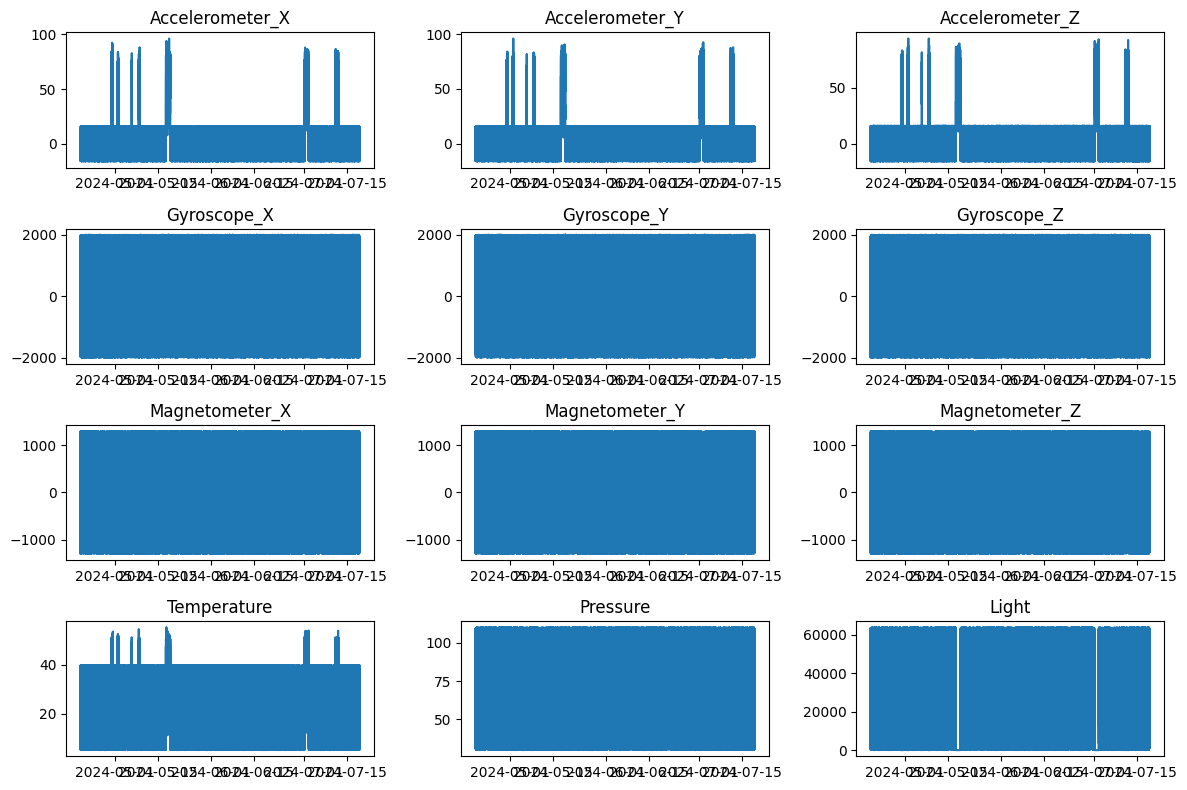

In [30]:
# Displaying statistical summary of the data
print(df.describe())

# Displaying the data
plt.figure(figsize=(12, 8))
for i, column in enumerate(df.columns):
    plt.subplot(4, 3, i + 1)
    plt.plot(df.index, df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [31]:
# Sava data to CSV file
df.to_csv('sensor_data.csv')